In [22]:
import torch
from adaptive_control_gym.envs import DroneEnv
from adaptive_control_gym.controllers import PPO
from tqdm import trange
import numpy as np
import pandas as pd

torch.set_grad_enabled(False)

n_params = 3
w_per_dim = 32
env_num = w_per_dim**n_params
search_dim = n_params
env = DroneEnv(
    env_num=env_num, gpu_id=0, seed = 1, 
    res_dyn_param_dim=0
)
res_dyn_param = torch.tensor([0.0, 0.0, 0.0], device = env.device)
agent = PPO(
    state_dim=env.state_dim, expert_dim=env.expert_dim, 
    adapt_dim=env.adapt_dim, action_dim=env.action_dim, 
    adapt_horizon=env.adapt_horizon, 
    act_expert_mode=1, cri_expert_mode=1,
    compressor_dim=n_params, search_dim=0,
    env_num=env_num, gpu_id=0)
loaded_agent = torch.load(
    '/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_RMA3_OOD_T120.pt',
    map_location='cuda:0',
)
agent.act.load_state_dict(loaded_agent['actor'].state_dict())
agent.cri.load_state_dict(loaded_agent['critic'].state_dict())
agent.adaptor.load_state_dict(loaded_agent['adaptor'].state_dict())
agent.compressor.load_state_dict(loaded_agent['compressor'].state_dict())

w = torch.linspace(-1, 1, w_per_dim, device=env.device)
ww = torch.stack(torch.meshgrid(*([w]*n_params)), dim=-1)
ww_flatten = ww.reshape(env_num, n_params)
err_mean = torch.zeros(env_num, device=env.device)

# generate 3d w from a sphere centerd at env.disturb_mean with radius env.disturb_std, angle=pi/4
theta = torch.arange(0, 2*torch.pi, np.pi/4, device=env.device)
phi = torch.arange(0, np.pi, np.pi/4, device=env.device)
xx = torch.sin(phi).unsqueeze(1) * torch.cos(theta).unsqueeze(0)
yy = torch.sin(phi).unsqueeze(1) * torch.sin(theta).unsqueeze(0)
zz = torch.cos(phi).unsqueeze(1) * torch.ones_like(theta).unsqueeze(0)
xyz_sphere = torch.stack([xx, yy, zz], dim=-1).reshape(-1, 3)

# dataframe to store results 
data = pd.DataFrame(columns=['z_star', 'z', 'e', 'z_err', 'z_star_err'])
for _ in range(1):
    e = torch.ones(3, device='cuda:0')*0.5# e = xyz_sphere[i]
    disturb = e * env.disturb_std + env.disturb_mean
    disturb = disturb * env.mass * 9.8
    for _ in trange(500):
        agent.last_state, agent.last_info = env.reset()

        # set env params
        env.disturb_period = 120
        env.mass[:,:] = env.mass_mean
        env.disturb = disturb
        env.decay[:,:] = env.decay_mean
        env.res_dyn_param[:,:] = env.res_dyn_param_mean
        env.force_scale[:,:] = env.force_scale_mean

        states, actions, logprobs, rewards, undones, infos = agent.explore_env(env, env.max_steps, deterministic=True, use_adaptor=False, predefined_e=ww_flatten)
        err_mean += infos['err_x'][-10:].mean(dim=0)
    err_mean /= 20
    # get the best w
    z_star = ww_flatten[err_mean.argmin()]
    z_star_err = err_mean.min()
    # get compressed e
    z = agent.compressor(e)
    z_match_idx = torch.norm(ww_flatten-z, dim=1).argmin()
    z_err = err_mean[z_match_idx].item()

    # save to dataframe
    data = data.append({
        'z_star': z_star.tolist(),
        'z': z.tolist(),
        'e': e.tolist(),
        'z_err': z_err,
        'z_star_err': z_star_err.item(),
    }, ignore_index=True)
# save to csv
# data.to_csv('results/baseline_z_star_mapping.csv')

# create pandas dataframe
data = pd.DataFrame(ww_flatten.cpu().numpy(), columns=['w1', 'w2', 'w3'])
data['err'] = err_mean.cpu().numpy()
# save to csv
data.to_csv('results/err_111_RMA3_OOD.csv')

100%|██████████| 500/500 [04:27<00:00,  1.87it/s]
/tmp/ipykernel_2605992/600077139.py:76: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
# plot e, z, z_star in 3 figures from dataframe
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
# data = pd.read_csv('results/z_star_mapping.csv')
# convert list string to list of float
# data['z'] = data['z'].apply(lambda x: eval(x))
# data['e'] = data['e'].apply(lambda x: eval(x))
# data['z_star'] = data['z_star'].apply(lambda x: eval(x))


fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
cc = np.arange(data.shape[0])/data.shape[0]
ax1.scatter(data['e'].apply(lambda x: x[0]), data['e'].apply(lambda x: x[1]), data['e'].apply(lambda x: x[2]), c=cc, cmap='jet', )
# plot z and z_star with jet cmap
ax2.scatter(data['z'].apply(lambda x: x[0]), data['z'].apply(lambda x: x[1]), data['z'].apply(lambda x: x[2]), c=cc, cmap='jet', label='z')
ax2.scatter(data['z_star'].apply(lambda x: x[0]), data['z_star'].apply(lambda x: x[1]), data['z_star'].apply(lambda x: x[2]), c=cc, cmap='jet', marker='x', label='z_star')
# plot connecting dash lines between z and z_star with jet cmap
for i in range(data.shape[0]):
    ax2.plot([data['z'][i][0], data['z_star'][i][0]], [data['z'][i][1], data['z_star'][i][1]], [data['z'][i][2], data['z_star'][i][2]], 'k--', alpha=0.2, linewidth=0.5)
# intrapolate z_err and z_star_err and plot in 3d
from scipy.interpolate import griddata
x = data['e'].apply(lambda x: x[0]).to_numpy()
y = data['e'].apply(lambda x: x[1]).to_numpy()
z = data['e'].apply(lambda x: x[2]).to_numpy()
z_err = data['z_err'].to_numpy()
z_star_err = data['z_star_err'].to_numpy()
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
zi = np.linspace(z.min(), z.max(), 100)
xi, yi, zi = np.meshgrid(xi, yi, zi)
zi_err = griddata((x, y, z), z_err, (xi, yi, zi), method='linear')
zi_star_err = griddata((x, y, z), z_star_err, (xi, yi, zi), method='linear')
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(xi[:, :, 0], yi[:, :, 0], zi_err[:, :, 0], cmap='jet', alpha=0.5, label='z_err')
ax3.plot_surface(xi[:, :, 0], yi[:, :, 0], zi_star_err[:, :, 0], alpha=0.5, label='z_star_err')
# set text with mean and variance of z_err and z_star_err
ax3.text2D(0.05, 0.95, f'z_err mean: {z_err.mean():.2f} std: {z_err.std():.2f}', transform=ax3.transAxes)
ax3.text2D(0.05, 0.90, f'z_star_err mean: {z_star_err.mean():.3f} std: {z_star_err.std():.4f}', transform=ax3.transAxes)
# set legend
ax1.legend()
# legend
ax2.legend()
# set titles
ax1.set_title('e')
ax2.set_title('z and z_star')
ax3.set_title('z error and z_star error')

In [23]:
compressed_point = agent.compressor(e).detach().cpu().numpy()
optimal_point = ww_flatten[err_mean.argmin()].detach().cpu().numpy()

In [24]:
# plot isosurface with w1, w2, w3 as input and err_x as output
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# data = pd.read_csv('results/err_000_RMA3.csv')
w1 = data['w1'].values
w2 = data['w2'].values
w3 = data['w3'].values
err = data['err'].values
# discretize err
# err = np.round(err, 2)
fig = go.Figure(data=[go.Isosurface(
    x=w1, y=w2, z=w3, value=err,
    isomin=err.min(), isomax=err.max(),
    opacity=0.2, surface_count=10, # number of isosurfaces, 2 by default: only min and max
    caps=dict(x_show=False, y_show=False, z_show=False)
)])
# mark compressed point
fig.add_trace(go.Scatter3d(
    x=[compressed_point[0]], y=[compressed_point[1]], z=[compressed_point[2]],
    mode='markers', marker=dict(size=4, color='red', opacity=0.8)
))
# mark optimal point
fig.add_trace(go.Scatter3d(
    x=[optimal_point[0]], y=[optimal_point[1]], z=[optimal_point[2]],
    mode='markers', marker=dict(size=4, color='green', opacity=0.8)
))
# show legend
fig.update_layout(scene = dict(
                    xaxis_title='w1',
                    yaxis_title='w2',
                    zaxis_title='w3'),
                    margin=dict(l=0, r=0, b=0, t=0))
# show label
fig.update_layout(scene = dict(
                    annotations=[
                        dict(
                            showarrow=False,
                            text="compressed point",
                            x=compressed_point[0],
                            y=compressed_point[1],
                            z=compressed_point[2],
                            xanchor="left",
                            xshift=10
                        ), 
                        dict(
                            showarrow=False,
                            text="optimal point",
                            x=optimal_point[0],
                            y=optimal_point[1],
                            z=optimal_point[2],
                            xanchor="left",
                            xshift=10
                        )
                    ]))
fig.show()

/home/pcy/miniconda3/envs/rlgpu/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



/tmp/ipykernel_2605992/2904335415.py:8: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



NameError: name 'err_mean_reshaped' is not defined

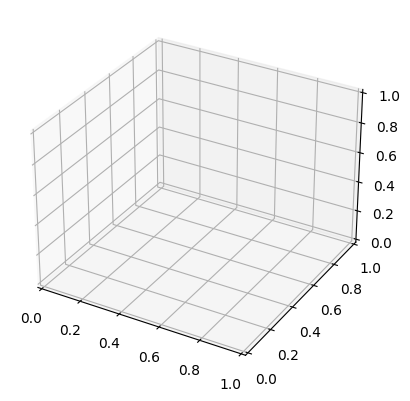

In [25]:
# plot w0, w1 and err_mean as colormap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(w.cpu().numpy(), w.cpu().numpy())
surf = ax.plot_surface(X, Y, err_mean_reshaped[:, :, 31], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)  
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
import numpy as np
compressed_value = agent.compressor(res_dyn_param).detach().cpu().numpy()
compressed_idx = (compressed_value / (2/w_per_dim)+w_per_dim/2).astype(np.int)
compressed_value = err_mean[compressed_idx[1], compressed_idx[0]]

In [ ]:
# plot err_mean
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(err_mean, cmap='jet')
plt.colorbar()
# rescale x, y axis
plt.xticks([0, w_per_dim-1], [-1, 1])
plt.yticks([0, w_per_dim-1], [-1, 1])
# show the point with min value
min_idx = np.unravel_index(np.argmin(err_mean, axis=None), err_mean.shape)
min_value = err_mean[min_idx]
plt.scatter(min_idx[1], min_idx[0], marker='x', color='red', s=100, label='searched minimum point')
plt.text(min_idx[1], min_idx[0]-2, f'{min_value:.2f}', color='red')
# show the compressed value
plt.scatter(compressed_idx[1], compressed_idx[0], marker='x', color='green', s=100, label='compressed point')
plt.text(compressed_idx[1]+2, compressed_idx[0]+2, f'{compressed_value:.2f}', color='green')
plt.legend()
plt.title('Error Mean along 2D Search Space, 100 runs, tested on [-1,-1]')

visualize high-dimentionsal input-output space. 

In [ ]:
# load compressor
import torch
loaded_agent = torch.load('/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_ActEx1_CriEx1_S1.pt', map_location='cuda:0')
err = loaded_agent['expert_err_x_final']
compressor = loaded_agent['compressor']

In [ ]:
# randomly generate 12d input data from -1 to 1
import torch
n = 10000
data = torch.rand(n, 12, device='cuda:0') * 2 - 1

In [ ]:
# generate data point from a sphere with torch
r = 0.8/0.3
n = 100
theta = torch.linspace(0, 2*torch.pi, n, device='cuda:0')
phi = torch.linspace(0, torch.pi, n, device='cuda:0')
x = r * torch.outer(torch.cos(theta), torch.sin(phi))
y = r * torch.outer(torch.sin(theta), torch.sin(phi))
z = r * torch.outer(torch.ones_like(theta), torch.cos(phi))
x = x.reshape(-1)
y = y.reshape(-1)
z = z.reshape(-1)
data = torch.stack([x, y, z], dim=1)

In [ ]:
# get output by compressor
torch.set_grad_enabled(False)
compressed_data = compressor(data)

In [ ]:
# visualize data and compressed_data with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
tsne = TSNE(n_components=2, random_state=0)
data_2d = tsne.fit_transform(data.cpu().numpy())
compressed_data_2d = tsne.fit_transform(compressed_data.cpu().numpy())
plt.scatter(data_2d[:, 0], data_2d[:, 1], label='data')
plt.scatter(compressed_data_2d[:, 0], compressed_data_2d[:, 1], label='compressed data')
# add final error text at left top corner
plt.text(-100, 80, f'final error: {err:.2f}')
plt.legend()
